In [2]:
import os 
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cdasws import CdasWs
import cdflib
import pyspedas
from datetime import datetime, timedelta

catalog = pd.read_excel(r"Sub-Alfvenic_Solar_Winds.xlsx")
catalog['Date'] = pd.to_datetime(catalog['Date'], errors='coerce')
catalog['Time'] = catalog['Time'].astype(str).str.strip()
catalog['datetime'] = pd.to_datetime(catalog['Date'].astype(str) + ' ' + catalog['Time'].astype(str), errors='coerce')
t_start = catalog['datetime'] - pd.Timedelta(days=2)
t_end = catalog['datetime'] + pd.Timedelta(days=2)


ACE = CdasWs()


In [3]:
catalog

,S. No.,M_A Minimum,Date,Time,Interplanetary Structure,Detecting Spacecraft,datetime
0,1,0.38,1992-11-09,19:15,MC,IMP 8,1992-11-09 19:15:00
1,2,0.90,1997-04-11,11:22,MC,Geotail,1997-04-11 11:22:00
2,3,0.82,1997-11-22,19:18,MC,Wind,1997-11-22 19:18:00
3,4,0.80,1999-04-27,04:17,HSS tail,"Wind, ACE",1999-04-27 04:17:00
4,5,0.60,1999-05-11,18:36,HSS tail,"Wind, ACE",1999-05-11 18:36:00
5,6,0.61,2000-03-29,06:37,MC,Wind,2000-03-29 06:37:00
6,7,0.67,2000-07-16,01:49,MC,"Geotail, ACE",2000-07-16 01:49:00
7,8,0.75,2000-07-16,04:49,MC,"Geotail, ACE",2000-07-16 04:49:00
8,9,0.66,2000-08-12,12:33,MC,Geotail,2000-08-12 12:33:00
9,10,0.98,2001-04-12,08:26,MC,ACE,2001-04-12 08:26:00


In [51]:
variables = ['ALL-VARIABLES']
filval = -1e31
for i in range(3,len(t_start)):
    time0 = t_start[i]
    time1 = t_end[i]
    datasets = ['AC_H3_MFI'] # one second lvl2 MFI data
    status_m, data_m = ACE.get_data(datasets, variables, time0, time1)
    Mag_Time = data_m['Epoch']
    arr = np.array(data_m)
    mask = (arr == filval) if np.isfinite(filval) else np.isclose(arr, filval)
    if mask.any():  # avoid unnecessary assignment if no fill
        arr[mask] = np.nan

    
    datasets = ['AC_H0_SWE'] # one second lvl2 Plasma data
    status_p, data_p = ACE.get_data(datasets, variables, time0, time1)
    Plasma_Time = data_p['Epoch']

    break

In [52]:
arr

array({'Epoch': VarCopy([datetime.datetime(1999, 4, 25, 4, 17, 0, 178000),
         datetime.datetime(1999, 4, 25, 4, 17, 1, 178000),
         datetime.datetime(1999, 4, 25, 4, 17, 2, 178000), ...,
         datetime.datetime(1999, 4, 29, 4, 16, 57, 678000),
         datetime.datetime(1999, 4, 29, 4, 16, 58, 678000),
         datetime.datetime(1999, 4, 29, 4, 16, 59, 678000)],
        shape=(345601,), dtype=object), 'Magnitude': VarCopy([4.621, 4.553, 4.535, ..., 9.186, 9.194, 9.211],
        shape=(345601,), dtype=float32), 'BRTN': VarCopy([[ 2.606, -3.806, -0.263],
         [ 2.6  , -3.728, -0.265],
         [ 2.65 , -3.671, -0.266],
         ...,
         [-6.286,  5.497,  3.826],
         [-6.474,  5.363,  3.719],
         [-6.523,  5.304,  3.761]], shape=(345601, 3), dtype=float32), 'BGSEc': VarCopy([[-2.611,  3.811,  0.1  ],
         [-2.604,  3.733,  0.091],
         [-2.654,  3.676,  0.084],
         ...,
         [ 6.29 , -5.848,  3.256],
         [ 6.478, -5.704,  3.163],
    

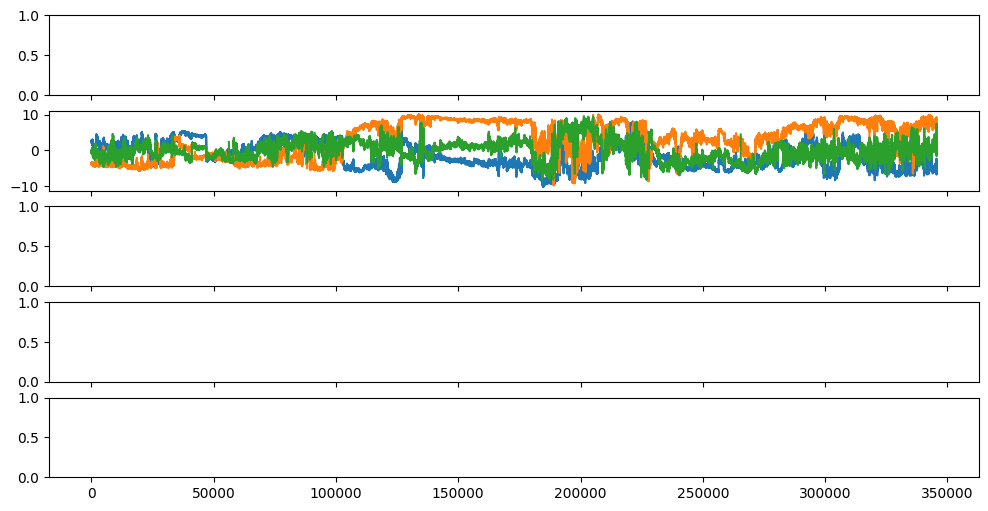

In [31]:
fig,axs = plt.subplots(5,1, figsize = (12,6),sharex = True)

axs[1].plot(a)